In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv('data.csv', index_col = 'ID')     #'P' = Patient    'H' = Healthy
df['class'] = df['class'].astype('category')

print('--- CLASS DISTRIBUTION ---')
print(df['class'].value_counts())

--- CLASS DISTRIBUTION ---
class
P    89
H    85
Name: count, dtype: int64


<h4> OPTIMAL N PCA COMPONENTS </h4>
I will test for the optimal N PCA components by measuring their precision score. A plot will be provided that displays the mean scores along with the standard deviations to get insight in PCA performance through iterations. 

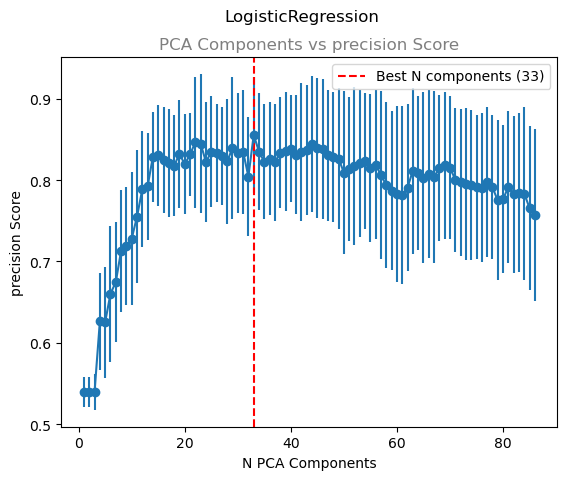

LogisticRegression best number of components: 33
LogisticRegression best score: 0.8555




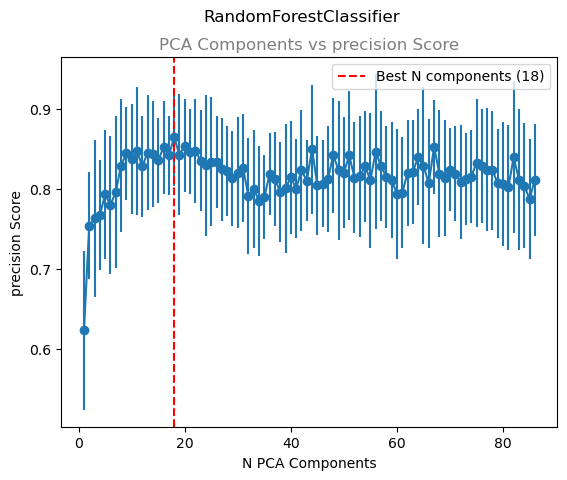

RandomForestClassifier best number of components: 18
RandomForestClassifier best score: 0.8646




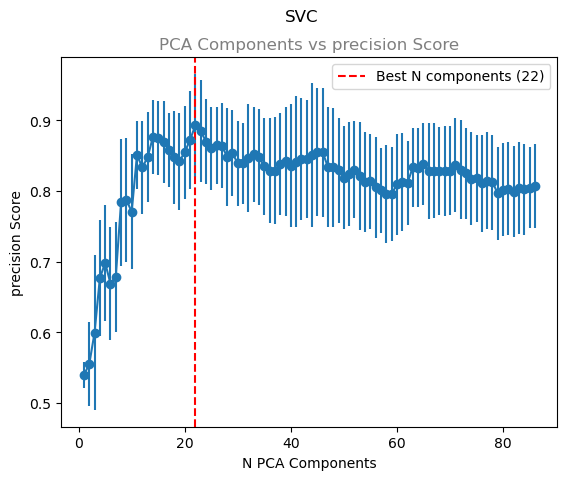

SVC best number of components: 22
SVC best score: 0.8931




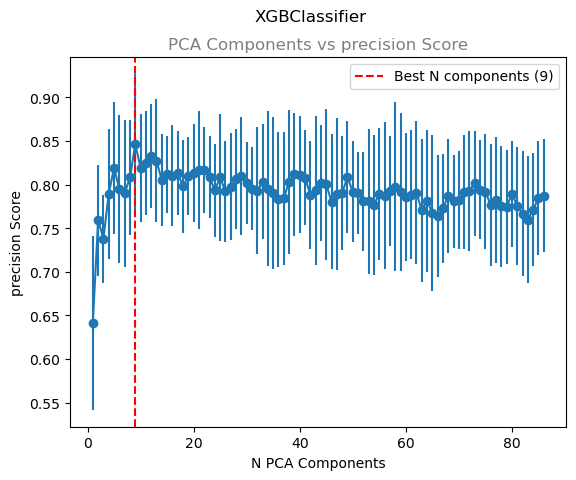

XGBClassifier best number of components: 9
XGBClassifier best score: 0.8464




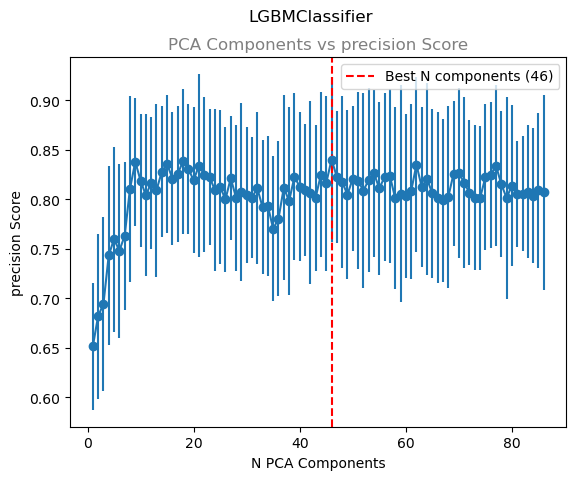

LGBMClassifier best number of components: 46
LGBMClassifier best score: 0.8401




In [83]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

X = df.drop('class', axis = 1)
y = LabelEncoder().fit_transform(df['class'])

max_components = (min(X.shape[0], X.shape[1]) - 1) // 2 #Since there are more columns than rows in the dataframe

classifier_list = [
    LogisticRegression(random_state = 1),
    RandomForestClassifier(random_state= 1), 
    SVC(random_state= 1), 
    XGBClassifier(random_state =1 ),
    LGBMClassifier(random_state= 1, verbose = -1)
]

for clf in classifier_list: 
    name = clf.__class__.__name__
    pipeline = make_pipeline(MinMaxScaler(feature_range= (-1,1)), clf)
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state= 1)

    best_score = 0
    best_n_components = 0
    scoring = 'precision'

    scores = list()
    for n_components in range(1, max_components + 1): 
        pca = PCA(n_components= n_components)
        X_pca = pca.fit_transform(X)
        
        cv_scores = cross_val_score(pipeline, X_pca, y, cv = cv, scoring = scoring)
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()
        
        scores.append((n_components, mean_score, std_score))
        
        if mean_score > best_score + 0.001: #More robust measure to see if the mean_score is actually better
            best_score = mean_score
            best_n_components = n_components

    components, means, stds = zip(*scores)
    plt.errorbar(components, means, yerr = stds, fmt = '-o')
    plt.xlabel('N PCA Components')
    plt.ylabel(f'{scoring} Score')
    plt.axvline(best_n_components, color = 'red', linestyle = '--', label = f'Best N components ({best_n_components})')
    plt.title(f'PCA Components vs {scoring} Score', alpha = 0.5)
    plt.suptitle(f'{name}')
    plt.legend()
    plt.show()

    print(f'{name} best number of components: {best_n_components}')
    print(f'{name} best score: {round(best_score, 4)}')
    
    print()
    print()